In [18]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [19]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
pickydeuterons = pd.read_csv("/Users/user/data/research/proton-deuteron/csv/pickydeuterons.csv")

In [20]:
picky = pd.merge(deuterons,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

picky = picky.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

picky.head()

,run,subrun,event,file_path,event_index,col_max_adc,ind_max_adc,col_activity_pixels,ind_activity_pixels,p,m,beamline_mass
0,8596,410,37727,/Users/user/data/research/proton-deuteron/rawd...,0,94.0,42.0,52,0,1,0,1822.06
1,9473,109,9096,/Users/user/data/research/proton-deuteron/rawd...,0,162.0,127.0,730,84,1,0,1869.80
2,9783,28,4265,/Users/user/data/research/proton-deuteron/rawd...,0,396.0,192.0,775,109,1,0,1826.83
3,8667,39,2811,/Users/user/data/research/proton-deuteron/rawd...,0,126.0,101.0,245,188,1,1,2032.23
4,9481,248,19285,/Users/user/data/research/proton-deuteron/rawd...,0,243.0,120.0,923,107,1,0,2331.43


In [21]:
i = 2
row = picky.iloc[i]

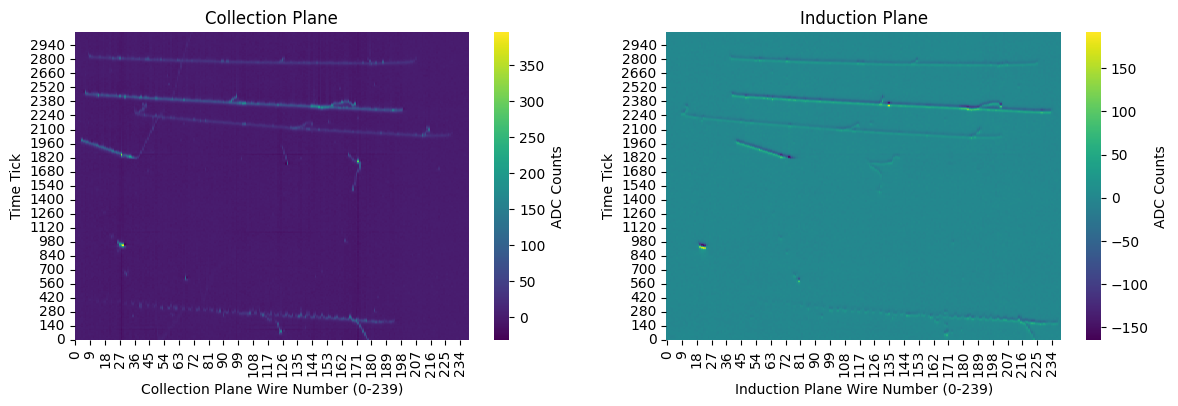

In [22]:
event = Event(row['file_path'], row['event_index'], threshold=15)

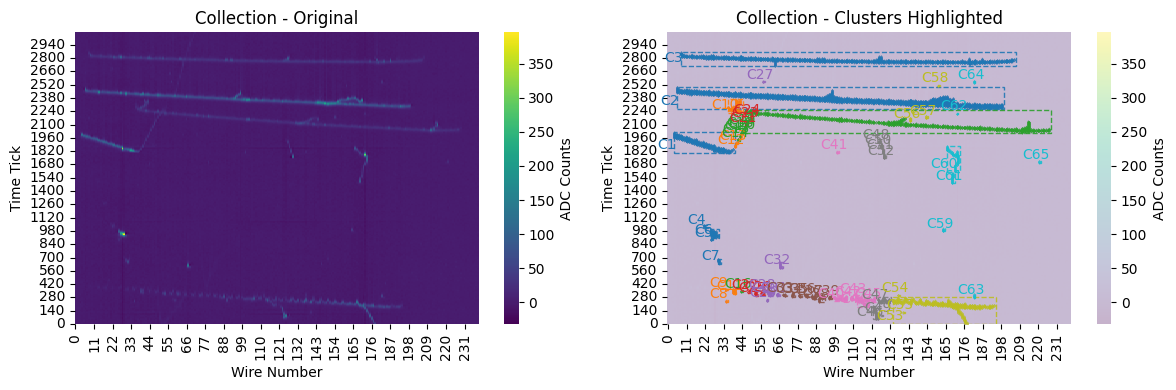

In [32]:
event.visualiseclusters(event.collection, event.connectedcr, 'Collection', mode='highlight')

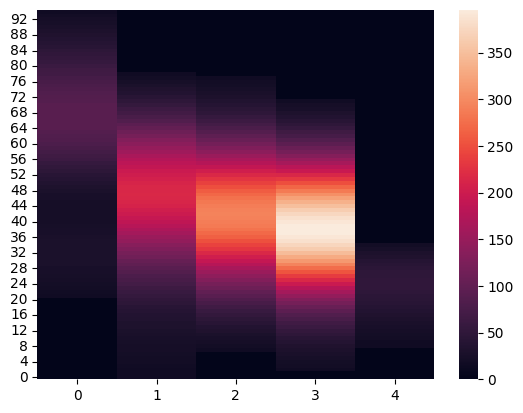

In [97]:
c = 5
sns.heatmap(event.connectedcr[c].image_intensity.T)
plt.gca().invert_yaxis()

This would not make it becuase of length cut on the clusters that I had used to remove actual noise.

In [98]:
maxing = np.max(event.connectedcr[c].image_intensity.T, axis=0)
maxing

array([ 91., 216., 293., 396.,  50.])

In [99]:
normalised = []

minimum = 0
maximum = np.max(maxing)

if maximum > minimum:
    normalised_signal = (maxing - minimum) / (maximum - minimum)
else:
    normalised_signal = np.zeros_like(maxing, dtype=float)
    print('Error: Max not greater than min in signal.')
normalised.append(normalised_signal)

adcdiff = [np.diff(signal) for signal in normalised]; 
maxdiff = [np.max(diff) for diff in adcdiff]; 

In [100]:
normalised

[array([0.22979798, 0.54545455, 0.73989899, 1.        , 0.12626263])]

In [101]:
adcdiff

[array([ 0.31565657,  0.19444444,  0.26010101, -0.87373737])]

In [102]:
maxdiff

[np.float64(0.31565656565656564)]

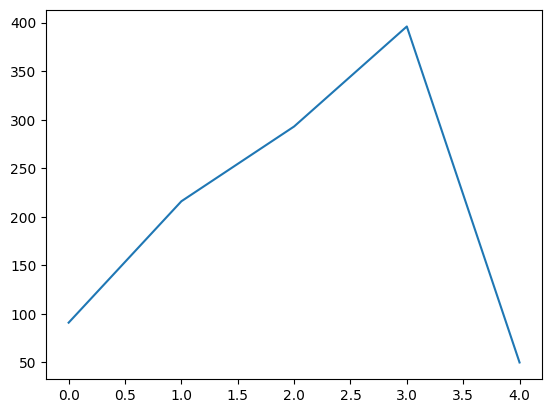

In [106]:
plt.plot(maxing)
plt.show()

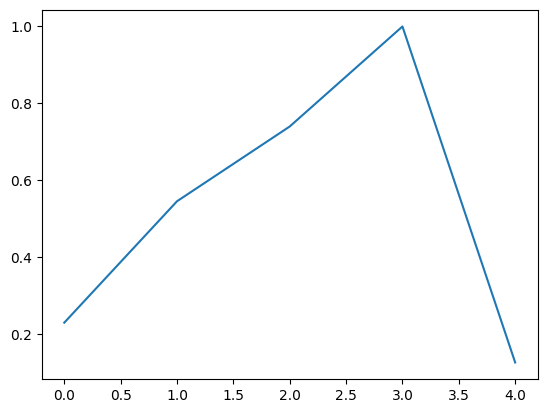

In [104]:
plt.plot(normalised[0]); plt.show()